# U-Net Example

This notebook gives a quick example of a UNET based on the blog post https://amaarora.github.io/2020/09/13/unet.html. 

## Getting Started: Connect to Google Drive

I want to apply the network to the Chiari data. I could copy the MATLAB file to the Google Colab instance every time but find it more convenient to connect my  Google Drive. You can read more about this step here: https://colab.research.google.com/notebooks/io.ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys, os

#Set Paths to Data Set(s)
data = '/content/gdrive/My Drive/Chiari/Data/normalizedChiariTrainingData-v2.mat'

#To Test if Code Works Use trial = 'testModel'
#trial = '11' 
trial = 'testModel'

#Set Path to Save Results
save_path = "/content/gdrive/My Drive/Chiari/Colab/results/" + trial + "/" #To Save in Trial Folder

if not(os.path.exists(save_path)):
  os.mkdir(save_path)


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import scipy.io as sio
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

#Load .mat Data Files
data = sio.loadmat(data)
print(sorted(data.keys()))

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['__globals__', '__header__', '__version__', 'masksTrain', 'meanDisplacementTrain', 'normalTrain', 'originalTrain', 'peakDisplacementTrain']
cuda:0


masks.shape = [51,256,256]
images.shape = = [51,3,256,256]


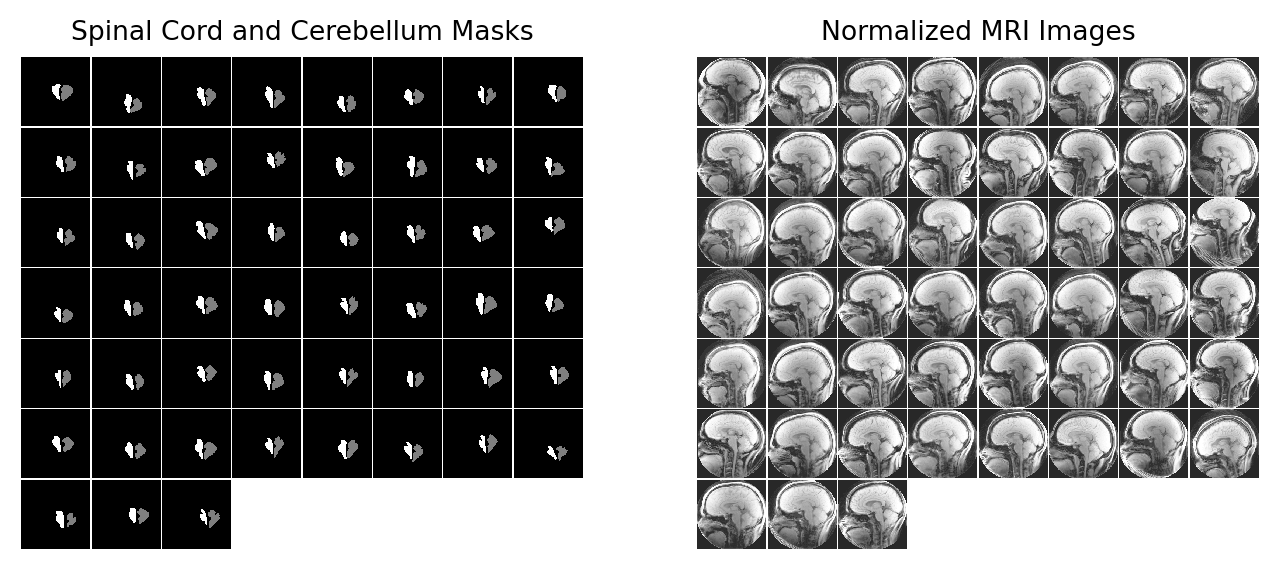

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


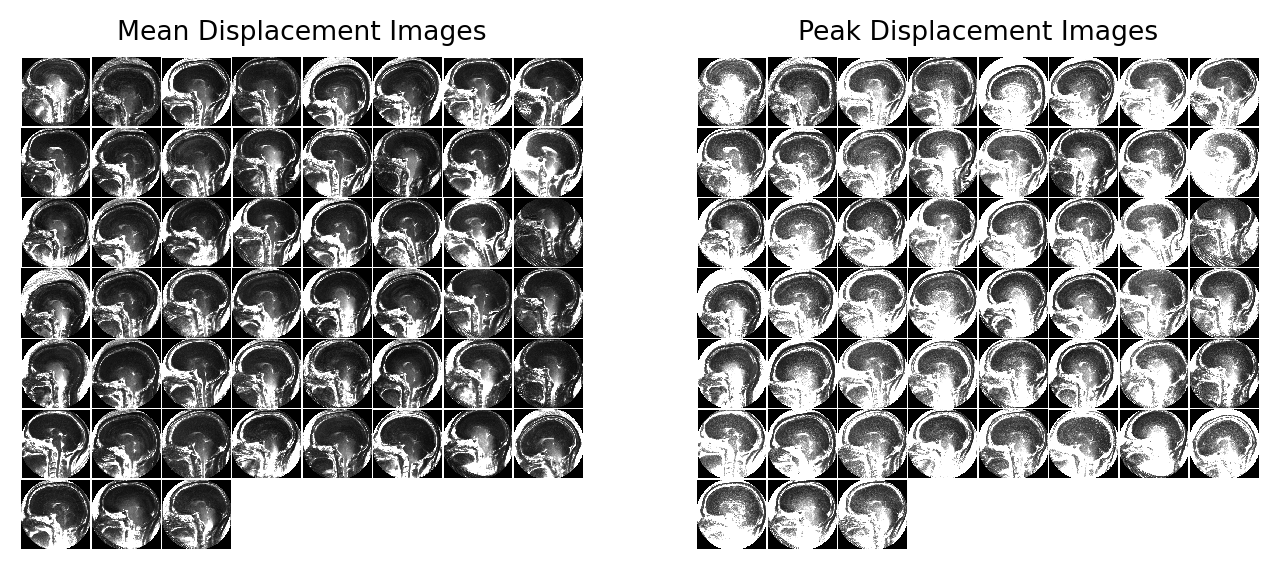

In [ ]:
#Extract DENSE Images [51,1,256,256] and Masks [51, 256, 256] from Data Sets
masks = torch.tensor(data['masksTrain'],dtype=torch.long, device=device).permute((2,0,1))
images_norm = torch.tensor(data['normalTrain'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
images_mean = torch.tensor(data['meanDisplacementTrain'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
images_peak = torch.tensor(data['peakDisplacementTrain'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
#Combine Normalized Magnitude, Mean, and Peak Displacement Images into a [51,3,256,256] Tensor 
images = torch.cat((images_norm, images_mean, images_peak),1)

#Print Shape of images and masks
print('masks.shape = [%d,%d,%d]' % masks.shape)
print('images.shape = = [%d,%d,%d,%d]' % images.shape)

#Print Data Sets as Images
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid((masks.unsqueeze(1)/torch.max(masks)).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Spinal Cord and Cerebellum Masks')
plt.margins(0, 0)

plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid((images_norm/torch.max(images_norm)).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Normalized MRI Images')
plt.margins(0, 0)
plt.show(1)

plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid((images_mean).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Mean Displacement Images')
plt.margins(0, 0)

plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid((images_peak).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Peak Displacement Images')
plt.margins(0, 0)
plt.show(2)


## Setting up the U-Net



In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1, device=device)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1, device=device)
        #conv layers: increase depth (& number of channels) of the input image

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024), device='cpu'):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2) #MaxPool: halves size of image
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), device='cpu'):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, device=device) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(572,572), device='cpu'):
        super().__init__() 
        self.encoder     = Encoder(enc_chs, device=device)
        self.decoder     = Decoder(dec_chs, device=device)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1, device=device) # Changed num_class=1 -> 3 above to make 3 channels
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out


In [ ]:
enc_chs = (3,16,32,64)
dec_chs = (64,32,16,)
net = UNet(enc_chs=enc_chs, dec_chs=dec_chs, device=device)
#Test U-Net
out = net.forward(images) 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Setting Up Iterations, Dice Function, and Data Sets/Storage



In [ ]:
iterations = 500 
min_loss = 100 #Initialize Min Loss

#Function for Dice
def Errors(k, label, prediction):
  masks_sum = torch.sum(label == k) + torch.sum(prediction == k)
  inter = torch.sum(torch.mul(label == k, prediction == k))
  diceError = (2 * (inter + 0.001)) / (masks_sum + 0.001) #Add 0.001 in case inter = 0
  return diceError

#Storing Data:
#Loss [Training, Validation]
prediction_loss = np.empty((iterations, 2))
#Dice [Training:Class 0, 1, 2, Validation:Class 0, 1, 2]
dice = np.empty((iterations, 6))

#Define Training Data:
inputs = images[0:41]
labels = masks[0:41]

#Define Validation Data:
inputsV = images[41:]
labelsV = masks[41:]

## Training Model

In [ ]:
#Define Loss Function: Cross-Entropy
loss = nn.CrossEntropyLoss()
#Define Optimizer: lBFGS
optimizer = optim.LBFGS(net.parameters(), line_search_fn='strong_wolfe')

for epoch in range(iterations):

  def closure():
      prediction_training = net(inputs) #Forward Pass- Outputs Predicted Masks
      Jc = loss(prediction_training, labels) #Calculate Loss
      optimizer.zero_grad() #Zero the Parameter Gradients
      Jc.backward() #Calculate Gradients
      return Jc

  
  optimizer.step(closure) #Update Weigths
  prediction_training = net(inputs) #Forward Pass (After Update)
  Jc = loss(prediction_training, labels) 

  #Store Training Loss
  prediction_loss[epoch,0] = Jc.item()

  #Validation
  prediction_valid = net(inputsV) #Validation Predicted Masks
  Jc_valid = loss(prediction_valid, labelsV)

  #Store Validation Loss
  prediction_loss[epoch,1] = Jc_valid.item()
  
  #Normalize Predictions
  predictedMask_training = torch.argmax(prediction_training, dim=1)
  predictedMask_valid = torch.argmax(prediction_valid, dim=1)

  #Dice For Each k=Class
  for k in range(3):

    #Training Data
    error_t = Errors(k, labels, predictedMask_training)
    #Store Results
    dice[epoch, k] = error_t

    #Validation Data
    error_v = Errors(k, labelsV, predictedMask_valid)
    #Store Results
    dice[epoch, k+3] = error_v

  #Save Lowest Validation Results:
  if prediction_loss[epoch, 1] < min_loss:
    torch.save(net, save_path + '/UNet_Model')
    torch.save(optimizer, save_path + '/UNet_Optimizer')
    min_iter = epoch
    min_loss = prediction_loss[epoch, 1]

print('Finished Training')
print('Minimum Iteration =', min_iter)


Finished Training
Minimum Iteration = 320


## Printing Results and Saving Data

In [ ]:
#Print Final Error Results
print('----------------------------+------------------------------')
print('|Training Loss: %.3f       |Min Validation Loss: %.3f   |'% (prediction_loss[min_iter,0], prediction_loss[min_iter,1]))
print('----------------------------+------------------------------')
print('|Initial Training Dice      | Final Training Dice         |')
print('----------------------------+------------------------------')
print('|Background:  %.6f      | %.6f                    |'% (dice[0,0],dice[min_iter,0]))
print('|Cerebellum: %.6f       | %.6f                    |'% (dice[0,1],dice[min_iter,1]))
print('|Brain Stem:  %.6f      | %.6f                    |'% (dice[0,2],dice[min_iter,2]))
print('----------------------------+------------------------------')
print('|Initial Validation Dice    | Final Validation Dice       |')
print('----------------------------+------------------------------')
print('|Background:  %.6f      | %.6f                    |'% (dice[0,3],dice[min_iter,3]))
print('|Cerebellum: %.6f       | %.6f                    |'% (dice[0,4],dice[min_iter,4]))
print('|Brain Stem:  %.6f      | %.6f                    |'% (dice[0,5],dice[min_iter,5]))
print('----------------------------+------------------------------')

#Save All Data to Excel Sheet in Google Drive
data = np.hstack((prediction_loss, dice))
data_df = pd.DataFrame(data)
data_df.columns = ['Training Loss', 'Validation Loss', 'Training Dice:0', 'Training Dice:1', \
                  'Training Dice:2', 'Validation Dice:0', 'Validation Dice:1', 'Validation Dice:2']
writer = pd.ExcelWriter(save_path + '/totalData.xlsx')
data_df.to_excel(writer,'page_1',float_format='%.6f')
writer.save()


----------------------------+------------------------------
|Training Loss: 0.023       |Min Validation Loss: 0.031   |
----------------------------+------------------------------
|Initial Training Dice      | Final Training Dice         |
----------------------------+------------------------------
|Background:  0.978046      | 0.995460                    |
|Cerebellum: 0.000000       | 0.915568                    |
|Brain Stem:  0.000000      | 0.870329                    |
----------------------------+------------------------------
|Initial Validation Dice    | Final Validation Dice       |
----------------------------+------------------------------
|Background:  0.978572      | 0.994515                    |
|Cerebellum: 0.000000       | 0.884937                    |
|Brain Stem:  0.000000      | 0.861231                    |
----------------------------+------------------------------


##  Plotting Results at Minimum Validation Loss

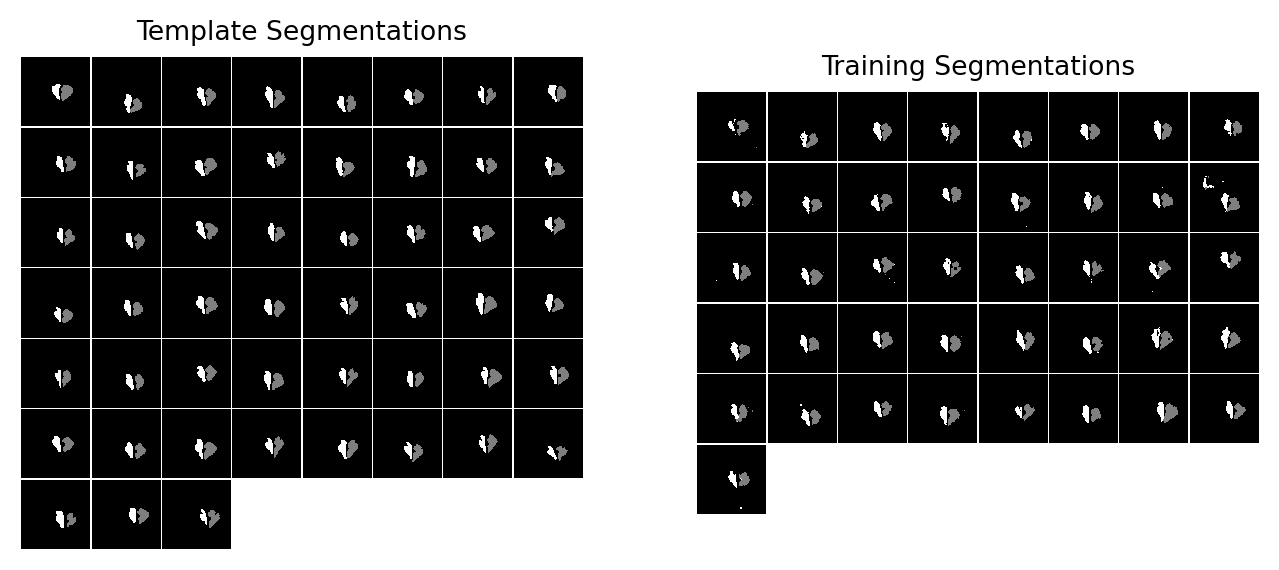

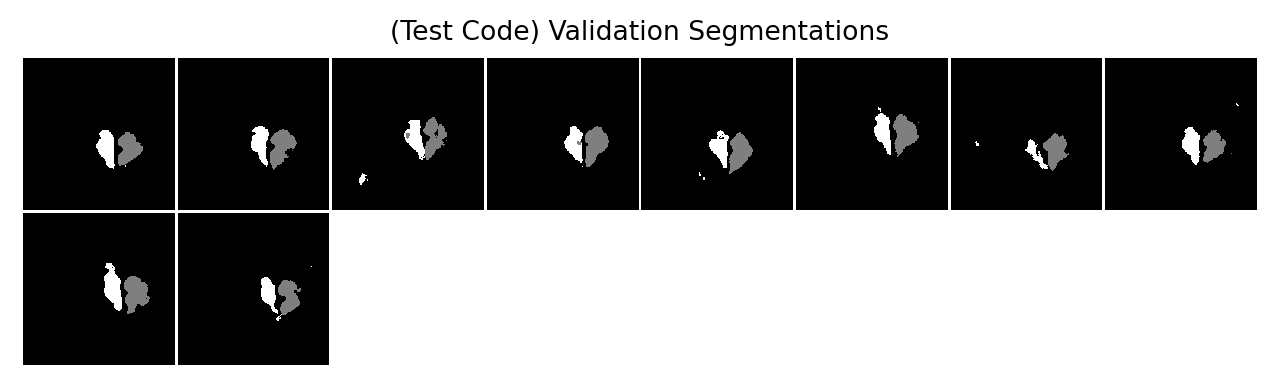

In [ ]:
#Load Model
model = torch.load(save_path + '/UNet_Model')
model.to(device)
model.eval()

#Training Masks at Minimum Validation Loss
masks_training = torch.argmax(model(inputs), dim=1)

#Plot Label Masks
plt.figure(4)
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid((masks.unsqueeze(1)/torch.max(masks)).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Template Segmentations')

plt.subplot(1,2,2)
imout = masks_training-torch.min(masks_training)
imout = imout / torch.max(imout)
plt.imshow(torchvision.utils.make_grid(imout.unsqueeze(1),8,padding=5,pad_value=1.0).cpu().permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('Training Segmentations')
plt.figure(4).savefig(save_path + '/maskComparison')
plt.show(4)

#Validation Masks at Minimum Validation Loss
masks_valid = torch.argmax(model(inputsV), dim=1)

plt.figure(5)
imout_valid = masks_valid-torch.min(masks_valid)
imout_valid = imout_valid / torch.max(imout_valid)
plt.imshow(torchvision.utils.make_grid(imout_valid.unsqueeze(1),8,padding=5,pad_value=1.0).cpu().permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.title('(Test Code) Validation Segmentations')
plt.figure(5).savefig(save_path + '/validationMasks')
plt.show(5)



## Plotting Loss and Dice Index

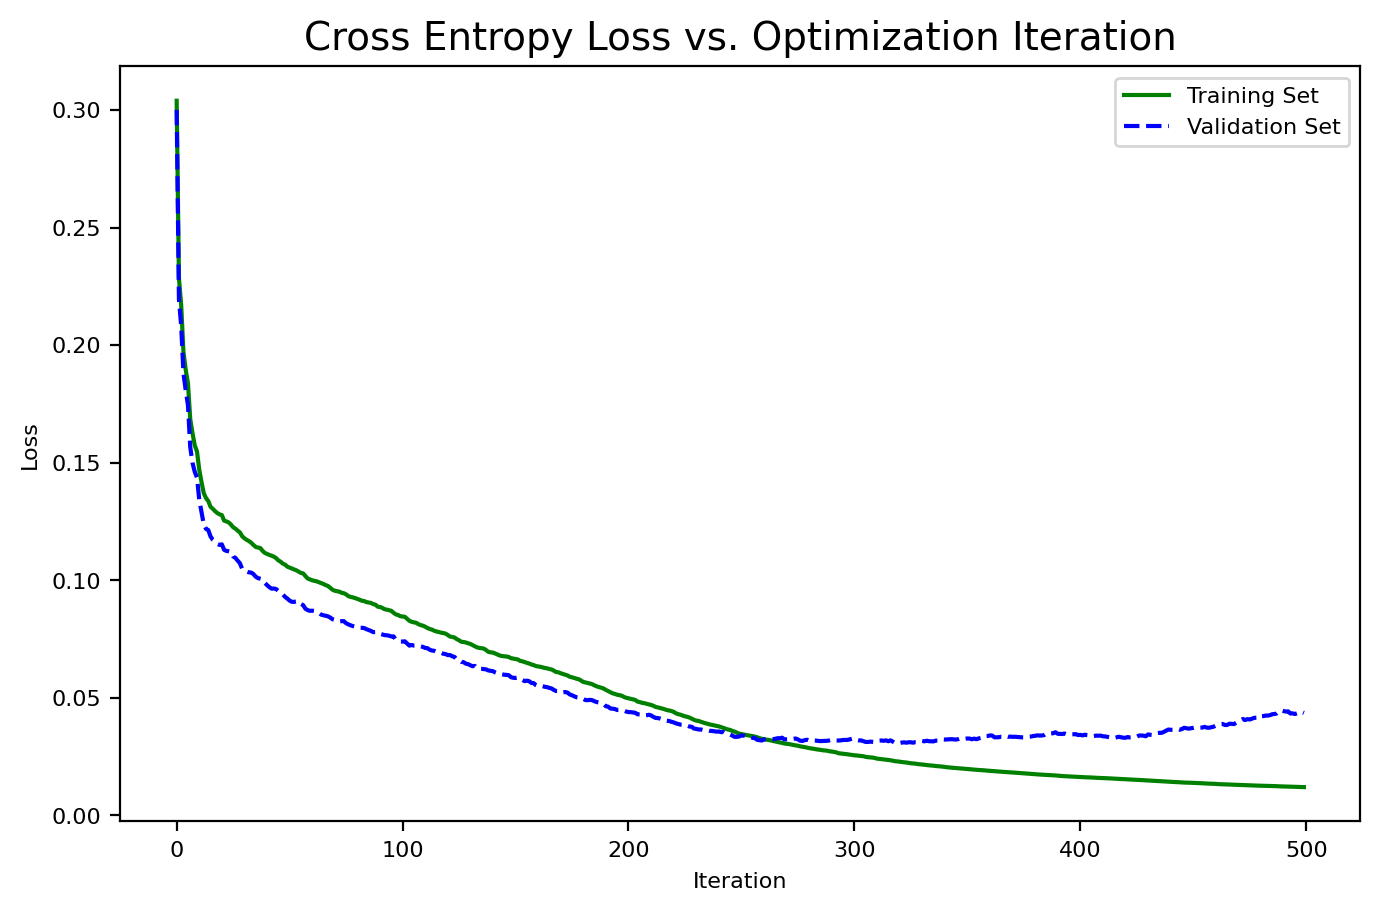

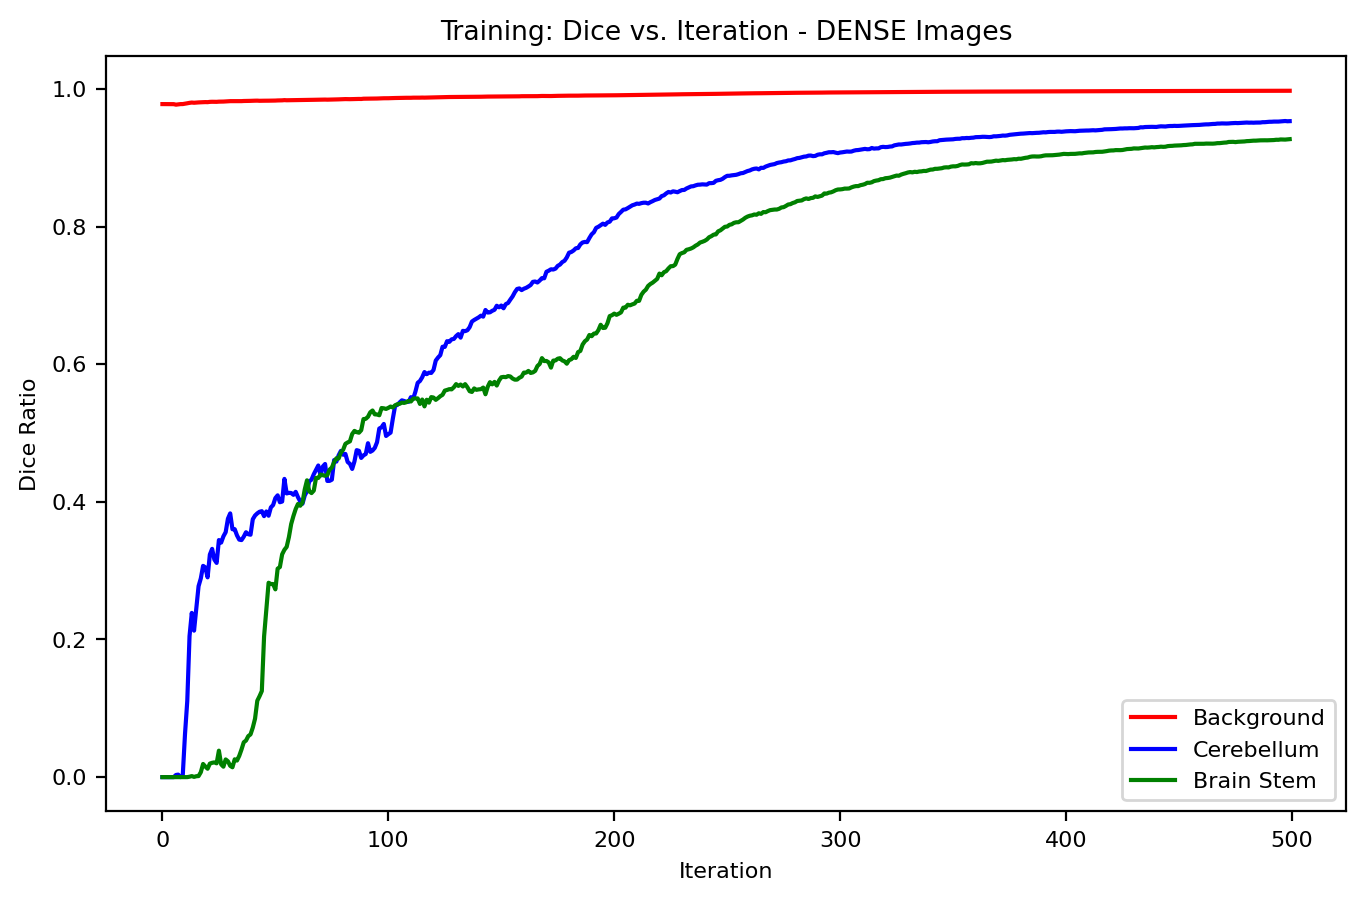

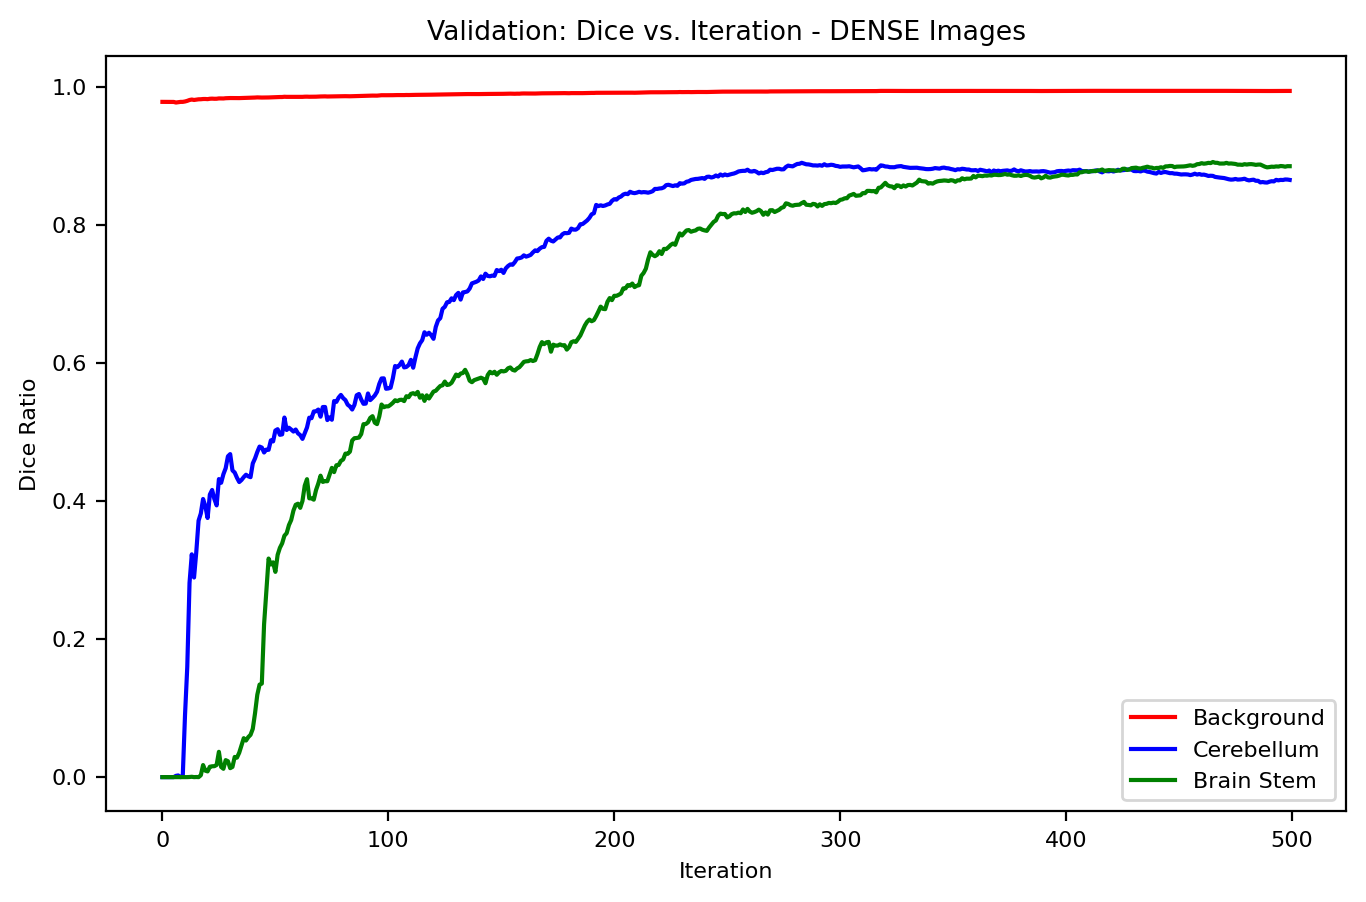

In [ ]:
#Plot Training and Validation
plt.figure(6)
plt.plot(range(iterations), prediction_loss[:,0], 'g')
plt.plot(range(iterations), prediction_loss[:,1], 'b--')
plt.title('Cross Entropy Loss vs. Optimization Iteration', fontsize=14)
plt.legend(['Training Set','Validation Set'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.figure(6).savefig(save_path + '/crossEntropyPlot')
plt.show(6)

#Plot Training Dice Index
plt.figure(7)
plt.plot(range(iterations), dice[:,0], 'r')
plt.plot(range(iterations), dice[:,1], 'b')
plt.plot(range(iterations), dice[:,2], 'g')
plt.legend(['Background', 'Cerebellum', 'Brain Stem'])
plt.title('Training: Dice vs. Iteration - DENSE Images')
plt.ylabel('Dice Ratio')
plt.xlabel('Iteration')
plt.figure(7).savefig(save_path + '/trainingDicePlot')
plt.show(7)

#Plot Validation Dice Index
plt.figure(8)
plt.plot(range(iterations), dice[:,3], 'r')
plt.plot(range(iterations), dice[:,4], 'b')
plt.plot(range(iterations), dice[:,5], 'g')
plt.legend(['Background', 'Cerebellum', 'Brain Stem'])
plt.title('Validation: Dice vs. Iteration - DENSE Images')
plt.ylabel('Dice Ratio')
plt.xlabel('Iteration')
plt.figure(8).savefig(save_path + '/validationDicePlot')
plt.show(8)
